# 2.0.5: Assessing trait model performance with spatial cross-validation

## Imports and config

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from src.conf.conf import get_config
from src.conf.environment import log

cfg = get_config()

## Assessing performance for trait X11 (SLA) across all trait sources

Models were trained on traits derived from three sources, sPlot-only, GBIF-only, and combined sPlot-GBIF, where sPlot trait data was preferred when trait values for both sPlot and GBIF were available for a given pixel. For each of the three trait sources, spatial lag was calculated using a spherical variogram to determine the geographic extent of spatial autocorrelation. The gridded trait data were there further grouped into an area-accurate hexagon mesh, where hexagons had a width of the spatial autocorrelation extent. These hexagons where then randomly assigned to one of 5 spatial folds, and spatial K-fold cross validation was performed during model training using these folds.

To ensure validation against both unseen (held-out) and also high-quality trait data, in the case of the GBIF and combined sPlot-GBIF sets, held-out validation sets consisted _only_ of sPlot-derived trait values located in the given hex-bins of the held-out fold.

In [2]:
from src.utils.dataset_utils import get_trait_models_dir, get_latest_run


trait_models_dir = get_trait_models_dir("X11_mean")
latest_run = get_latest_run(trait_models_dir)
trait_sources = ["gbif", "splot", "splot_gbif"]

Store each the evaluation results dataframe from each trait source in a dictionary.

In [3]:
from pathlib import Path


def cv_results(run_path: Path) -> dict[str, pd.DataFrame]:
    trait_sources = ["gbif", "splot", "splot_gbif"]
    cv_results: dict[str, pd.DataFrame] = {}
    for src in trait_sources:
        cv_res = pd.read_csv(
            run_path / src / cfg.train.eval_results, index_col=0, header=[0, 1]
        )
        cv_results[src] = cv_res
    return cv_results

Plot the key spatial CV performance metrics for each trait source.

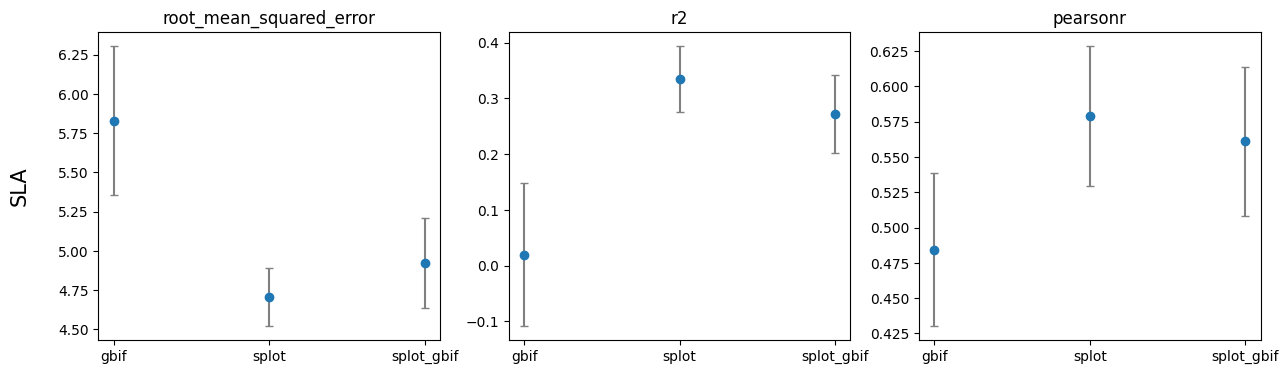

In [4]:
import json
from typing import Iterable, Sequence

from matplotlib.axes import Axes
import seaborn as sns
from matplotlib.colors import Normalize


def plot_trait_row(
    axes: Sequence[Axes], trait: str, cv_res: dict[str, pd.DataFrame]
):
    stats = ["root_mean_squared_error", "r2", "pearsonr", "pearsonr (full)"]

    for stat, ax in zip(stats, axes):
        if ax == axes[0]:
            with open("reference/trait_mapping.json", "r") as f:
                trait_mapping = json.load(f)
                trait_short = trait_mapping[trait.split("_")[0].split("X")[1]]["short"]
            ax.set_ylabel(trait_short, fontsize=15, labelpad=20)

        x = cv_res.keys()
        y = [abs(df[stat]["mean"].values[0]) for _, df in cv_res.items()]
        y_err = [df[stat]["std"].values[0] for _, df in cv_res.items()]

        ax.errorbar(
            x=x,
            y=y,
            yerr=y_err,
            fmt="o",
            ecolor="gray",
            capsize=3,
            capthick=1,
            zorder=1,
        )
        ax.set_title(stat)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_trait_row(axes, "X11_mean", cv_results(latest_run))

Now plot CV performance for all traits trained so far.

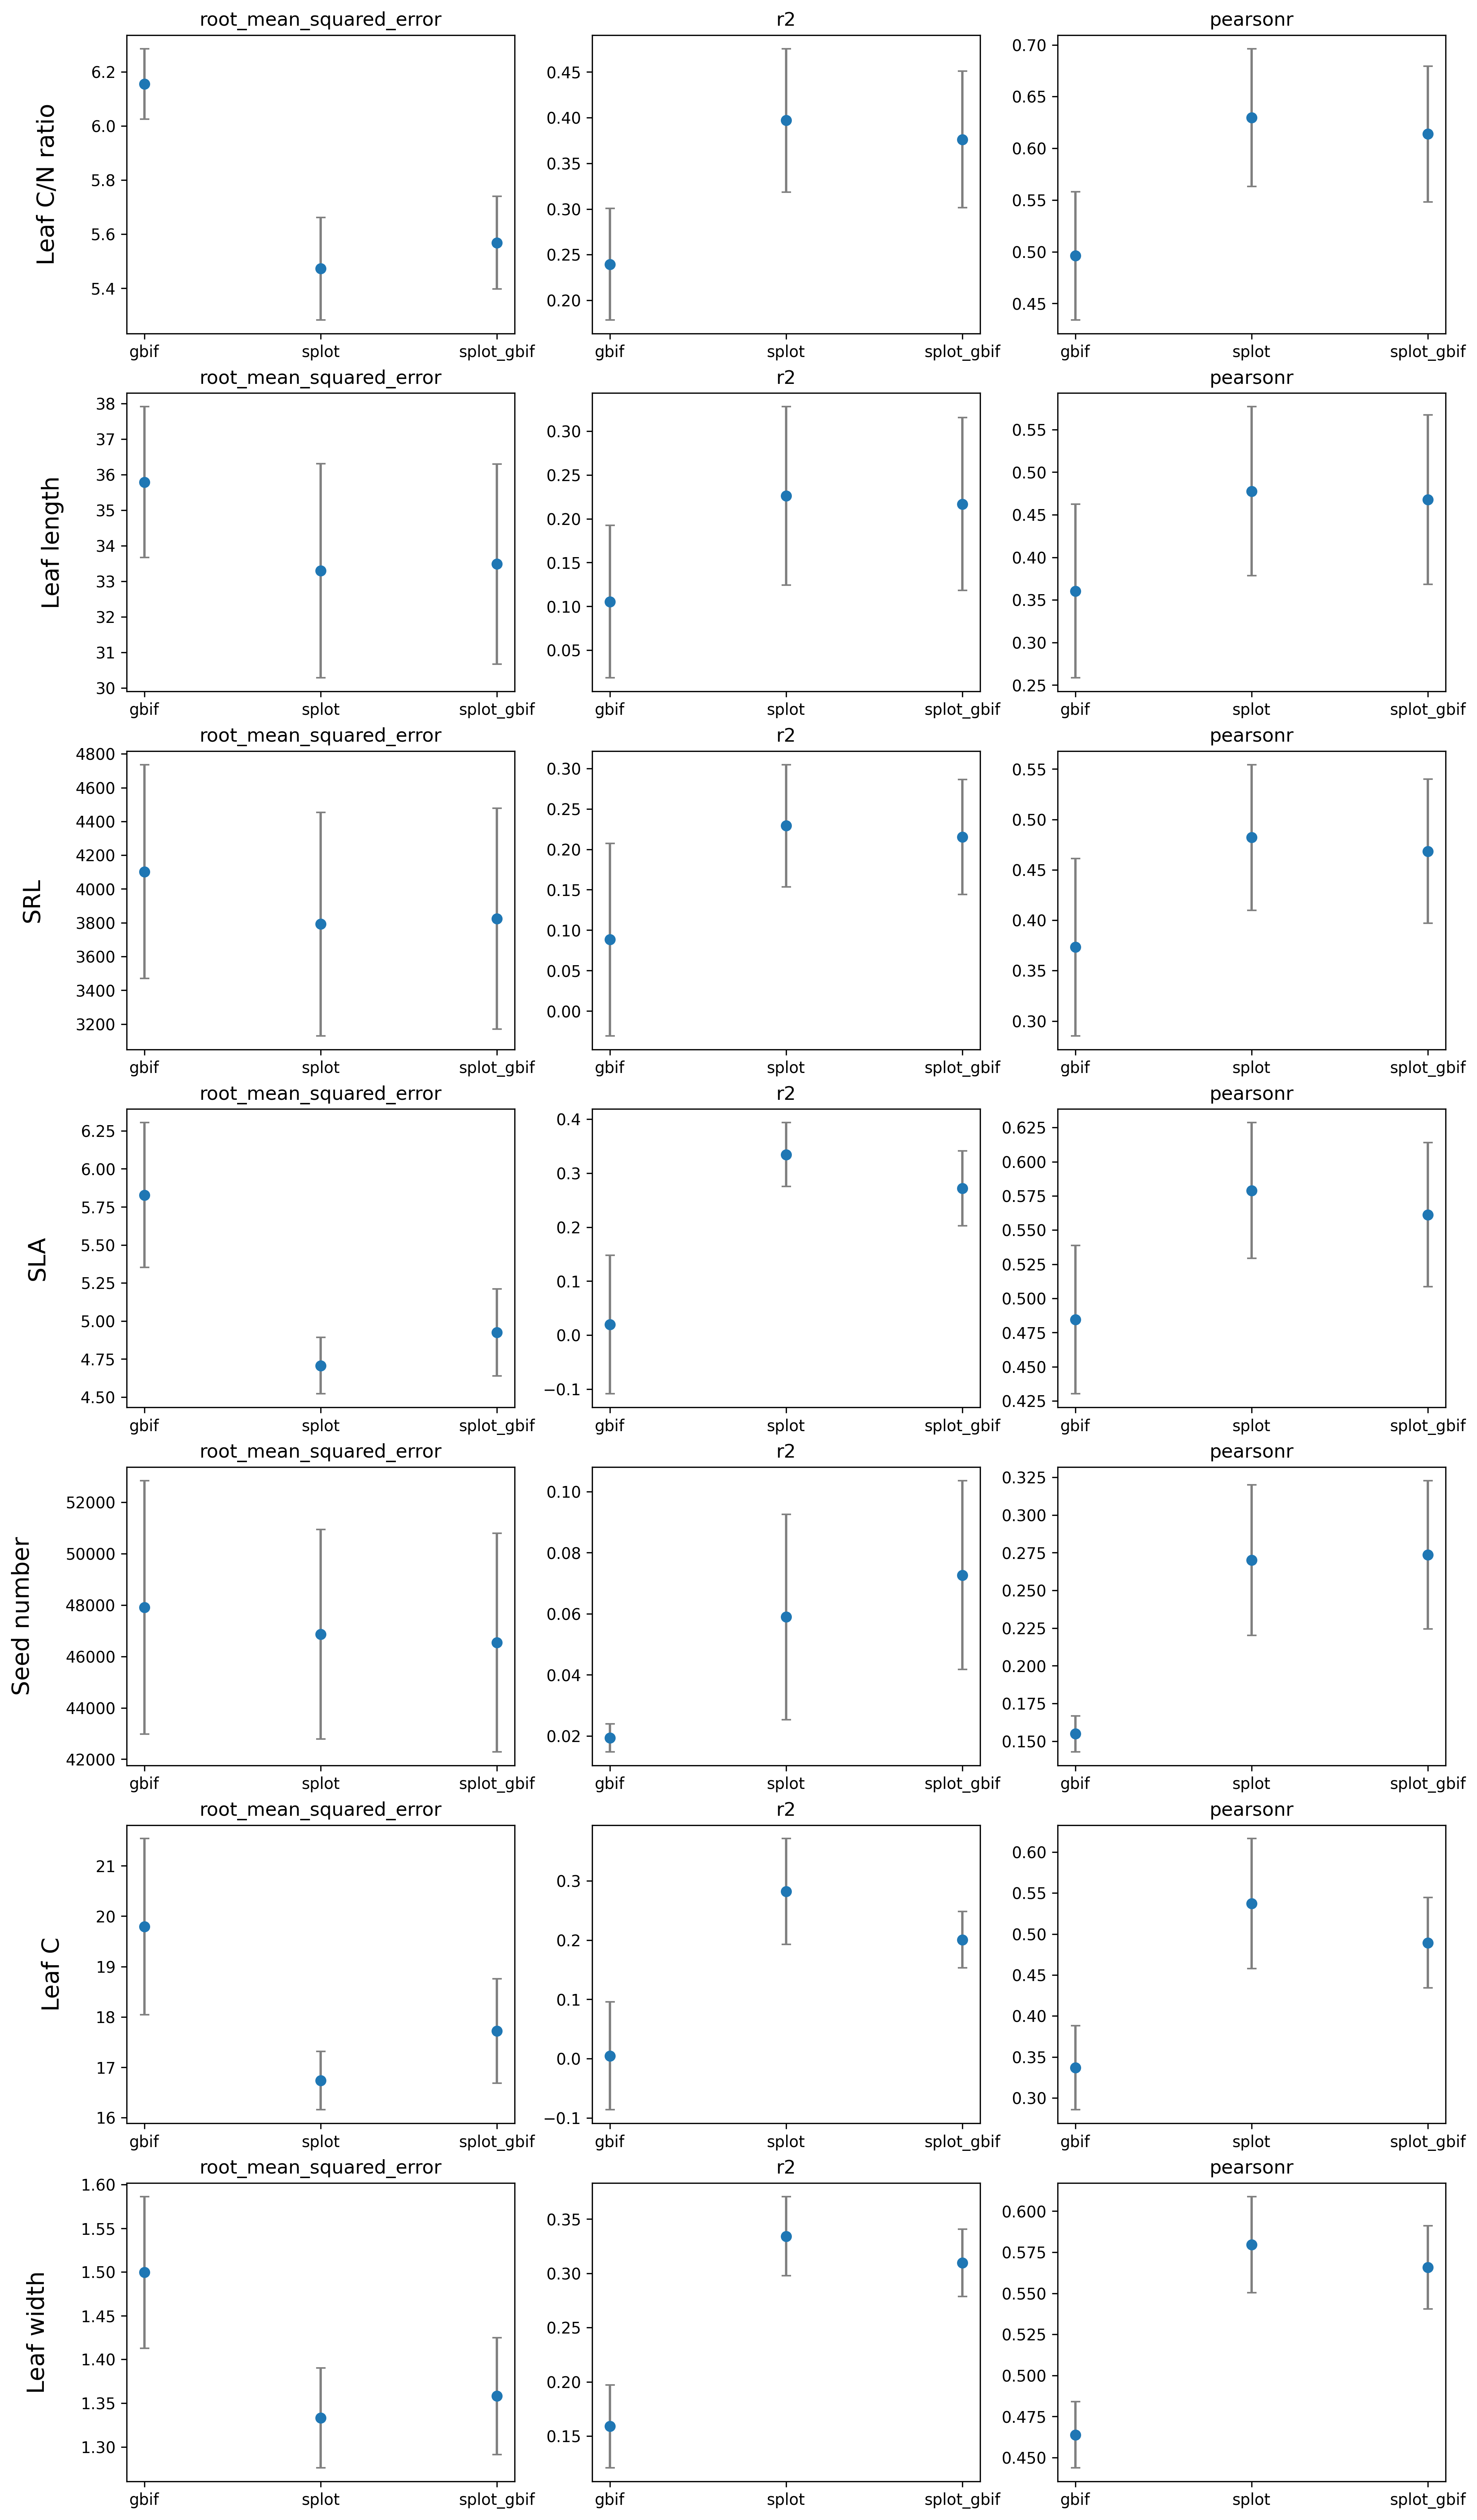

In [5]:
from src.utils.dataset_utils import get_models_dir

trait_dirs = [
    dir for dir in get_models_dir().glob("*") if dir.is_dir() and dir.name != "X14_mean"
]
fig, ax = plt.subplots(len(trait_dirs), 3, figsize=(15, 4 * len(trait_dirs)), dpi=300)
for trait_dir, ax_row in zip(trait_dirs, ax):
    latest_run = get_latest_run(trait_dir / "autogluon")
    plot_trait_row(ax_row, trait_dir.name, cv_results(latest_run))